"As a first demonstration of the ability of this algorithm to recover the latent structure responsible
for having generated observed data, we applied the Gibbs sampler for the infinite linear-Gaussian
model to a simulated data set consisting of 100 6×6 images, each generated by randomly assigning
a feature to each image to a class with probability 0.5, and taking a linear combination of the
weights associated with features to which the images were assigned (a similar data set was used by
Ghahramani, 1995).  The non-zero elements of A were all equal to 1.0, and σX was set to
0.5, introducing a large amount of noise. The data were generated from a model with K+ = 4"

In [7]:
import math
import numpy as np
import time
def timer(f, *args, **kwargs):
    start = time.clock()
    ans = f(*args, **kwargs)
    return ans, time.clock() - start
def report(fs, *args, **kwargs):
    ans, t = timer(fs[0], *args, **kwargs)
    print('%s: %.1f' % (fs[0].__name__, 1.0))  
    for f in fs[1:]:
        ans_, t_ = timer(f, *args, **kwargs)
        print('%s: %.1f' % (f.__name__, t/t_))

In [1]:
np.random.seed(123)
N = 100 
K_plus = 4 
D = 36 
sigmaX = 0.5

# Simulated data based on the example in the paper
A = np.array(( 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, \
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0, 0, 0,1, 1, 1,0, 0, 0,  1, 0, 1, 0, 0, 0, 1, 1, 1,    \
             1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0, 0, 0, 0, 0,0, 0, 0, 0, 0,0 ,0, 0, \
             0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,0, 0, 0, 0,1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)).reshape(4, D)

Z_zero = np.zeros((N, K_plus))
X = np.zeros((N, D))
I = np.identity(D) * sigmaX

for i in range(N):
    Z_zero[i,:] = (np.random.uniform(0,1,K_plus) > .5).astype(int)
    while (all(Z_zero[i,:] == 0)):
        Z_zero[i,:] = (np.random.uniform(0,1,K_plus) > .5).astype(int)
    X[i,:] = np.random.normal(0,1, (1,D)).dot(I)+Z_zero[i,:].dot(A)

In [2]:
%%file Original_functions.py
import numpy as np




#prior of IBP
def IBP_prior(alpha, N):

    res = np.zeros((N, 1000))

    #First person
    temp = np.random.poisson(alpha)
    if temp>0:
        res[0,0:temp] = np.ones(temp)

    #the rest with Bernoulli + Poisson
    K_plus = temp
    for i in range(1,N):
        for j in range(K_plus):
            p = np.sum(res[0:i,j])/(i+1)
    #sample as Bernoulli with rate m_k/i
            if np.random.uniform(0,1) < p:
                res[i,j] = 1
    #The "untouched" dishes have poisson distribution with rate alpha/i
        temp = np.random.poisson(alpha/(i+1))
    #None zero
        if temp > 0:
    #The "new dishes", silimar logic as the very first person
            res[i, K_plus : K_plus + temp] = np.ones(temp)
    #length of new person's first few "bernoulli" choice 
            K_plus = K_plus + temp
    
    res = res[:,0:K_plus]
    return np.array((res, K_plus))

#log p(X|Z,σ_x ,σ_A )

def log_p(X, Z, Sigma_X, Sigma_A, K, D, N):
    M = Z.T.dot(Z)+(Sigma_X**2/Sigma_A**2)*np.identity(K)
    #exponential term
    log_exponential_term = -.5/(Sigma_X**2)*np.trace( (X.T.dot( np.identity(N)-Z.dot(np.linalg.inv(M).dot(Z.T)) )).dot(X))
    return (-1)*np.log(2*np.pi)*N*D*.5 - np.log(Sigma_X)*(N-K)*D - np.log(Sigma_A)*K*D - .5*D*np.log(np.linalg.det(M)) + log_exponential_term

Overwriting Original_functions.py


"The Gibbs sampler was initialized with K+ = 1, choosing the feature assignments for the first
column by setting $z_{i1}$ = 1 with probability 0.5. σA, σX , and α were initially set to 0.5, 1.7, and
1 respectively"

In [3]:
from Original_functions import IBP_prior,log_p

alpha = 1
sigmaX = 1.7
sigmaA = 0.5
N=Z_zero.shape[0]
D=Z_zero.shape[1]
Z, Kplus = IBP_prior(alpha, N)
%timeit log_p(Z_zero, Z, sigmaX, sigmaA, Kplus, D, N)

The slowest run took 23.28 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 113 µs per loop


In [4]:
%%file sampler_origin.py
from __future__ import division
import numpy as np
import math
from Original_functions import IBP_prior, log_p

def sampler_original(X, niter, BURN_IN, sigmaX, sigmaA,alpha, N, D, maxNew):
    SAMPLE_SIZE = niter - BURN_IN
    final_Z=np.zeros((SAMPLE_SIZE,N,20))
    final_K=np.zeros((SAMPLE_SIZE,1))
    final_sigma_X=np.zeros((SAMPLE_SIZE,1))
    final_sigma_A=np.zeros((SAMPLE_SIZE,1))
    final_alpha=np.zeros((SAMPLE_SIZE,1))
    Z, Kplus = IBP_prior(alpha, N)
    count=0

    for j in range(niter):
        if((j+1) > BURN_IN):
            final_Z[count,:,0:Kplus] = Z
            final_K[count] = Kplus
            final_sigma_X[count] = sigmaX
            final_sigma_A[count] = sigmaA
            final_alpha[count] = alpha
            count = count + 1

        for i in range(N):
            for k in range(Kplus):
                if k >= Kplus:
                    break     
                if Z[i,k] > 0:
                    if (np.sum(Z[:,k])- 1) <= 0:
                        Z[:,k:(Kplus-1)] = Z[:,(k+1):Kplus]
                        Kplus = Kplus-1
                        Z = Z[:,0:Kplus]
                        continue
           
           #M-H algorithm for Z
                P = np.zeros(2)
                #set Z[i,k] = 0 and calculate posterior probability
                Z[i,k] = 0
                P[0] = log_p(X, Z, sigmaX, sigmaA, Kplus, D, N) + np.log(N-np.sum(Z[:,k])) - np.log(N)
                #set Z[i,k] = 1 and calculate posterior probability
                Z[i,k] = 1
                P[1] = log_p(X, Z,sigmaX, sigmaA, Kplus, D, N)  + np.log(np.sum(Z[:,k])- 1) - np.log(N)

                P = np.exp(P - max(P))
                U = np.random.uniform(0,1)
                if U<(P[1]/(np.sum(P))):
                    Z[i,k] = 1
                else:
                    Z[i,k] = 0   
  
            #M-H algorithm for k
            # Set the number of upper bound as 3
            maxNew = 3
            #Sample number of new features
            prob = np.zeros(maxNew)
            alphaN = alpha/N     
            for kNew in range(maxNew):
                Z_temp = Z
                if kNew > 0:
                    addCols = np.zeros((N,kNew))
                    addCols[i,:] = 1
                    Z_temp = np.hstack((Z_temp, addCols))

                pois = kNew*np.log(alphaN) - alphaN - np.log(math.factorial(kNew))
                kk = Kplus+kNew
                lik = log_p(X, Z_temp, sigmaX, sigmaA, kk, D, N)
                prob[kNew] = pois + lik
            prob = np.exp(prob - max(prob))
            prob = prob/sum(prob)

            U = np.random.uniform(0,1)
            p = 0
            kNew=0
            for new in range(maxNew):
                p = p + prob[new]
                if U < p:
                    kNew = new
                    break
            if kNew > 0:
                addCols = np.zeros((N,kNew))
                addCols[i,:] = 1
                Z = np.hstack((Z, addCols))
            Kplus = Kplus + kNew 
        Log_L1 = log_p(X, Z, sigmaX, sigmaA, Kplus, D, N )

        #update sigmaX  
        temp_unif = np.random.uniform(0,1)/30
        if np.random.uniform(0,1) < .5:
            sigmaX_new = sigmaX - temp_unif
        else:
            sigmaX_new = sigmaX + temp_unif
    
        Log_L_New = log_p(X, Z, sigmaX_new, sigmaA, Kplus, D, N)
        sigmaX_a = np.exp(min(0,Log_L_New-Log_L1))       
        U = np.random.uniform(0,1)
        if U < sigmaX_a:
            sigmaX = sigmaX_new


        #update sigmaA
        temp_unif1 = np.random.uniform(0,1)/30
        if np.random.uniform(0,1) < .5:
            sigmaA_new = sigmaA - temp_unif1
        else:
            sigmaA_new = sigmaA + temp_unif1
    
        Log_L_New = log_p(X, Z, sigmaX, sigmaA_new, Kplus, D, N)
        sigmaX_a = np.exp(min(0,Log_L_New-Log_L1))
        U = np.random.uniform(0,1)
        if U < sigmaX_a:
            sigmaA = sigmaA_new
        
        #update alpha
        Harmonic_N = 0.
        for i in range(1, N+1):
            Harmonic_N += 1.0/i
        alpha = np.random.gamma(1+Kplus, 1/(1+Harmonic_N))  
 
    return(final_Z, final_K, final_sigma_A, final_sigma_X, final_alpha, Z)

Overwriting sampler_origin.py


parameters α, σX , and σA over 1000 iterations of sampling.

In [5]:
niter = 1000
sigmaX = 1.7
sigmaA = 0.5
alpha = 1.0
maxNew = 4
BURN_IN = 200
SAMPLE_SIZE = niter-BURN_IN

In [6]:
from sampler_origin import sampler_original
from Original_functions import IBP_prior, log_p
final_Z, final_K, final_sigma_A, final_sigma_X, final_alpha, Z= sampler_original(X, niter, BURN_IN, sigmaX, sigmaA,alpha, N, D, maxNew)

In [12]:
Z_final=Z[:,0:4]

XRecreated=np.zeros((N,D))
sigma_X=final_sigma_X[SAMPLE_SIZE-1]
sigma_A=final_sigma_A[SAMPLE_SIZE-1]
A_inf=np.dot(np.dot(np.linalg.inv((np.dot(Z_final.T,Z_final)+(sigma_X/sigma_A)*np.eye(4))),Z_final.T),X)

for i in range(N):
    XRecreated[i,:]=np.dot(Z_final[i,:],A_inf[0:4,])

100 images were generated as binary linear combinations of four sets of
class weights, shown in the images on the top. The images on the bottom are the posterior
mean weights A for a single sample of Z after 200 iterations, ordered to match the true
classes. 

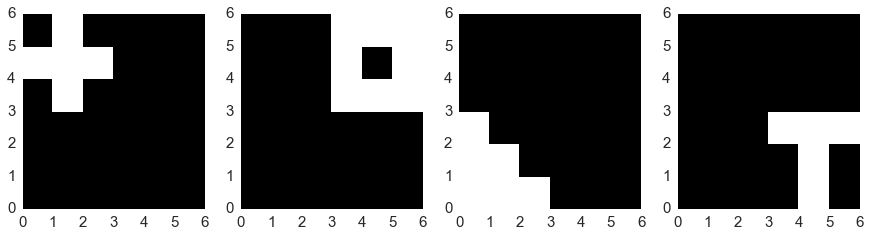

In [13]:
#Initial plots
plt.figure(num=None, figsize=(15,3.5), dpi=100, facecolor='w', edgecolor='k')
plt.subplot(141)
plt.pcolormesh(A[0,:].reshape(6,6),cmap=plt.cm.gray)     
plt.subplot(142)
plt.pcolormesh(A[1,:].reshape(6,6),cmap=plt.cm.gray)  
plt.subplot(143)
plt.pcolormesh(A[2,:].reshape(6,6),cmap=plt.cm.gray)  
plt.subplot(144)
plt.pcolormesh(A[3,:].reshape(6,6),cmap=plt.cm.gray) 

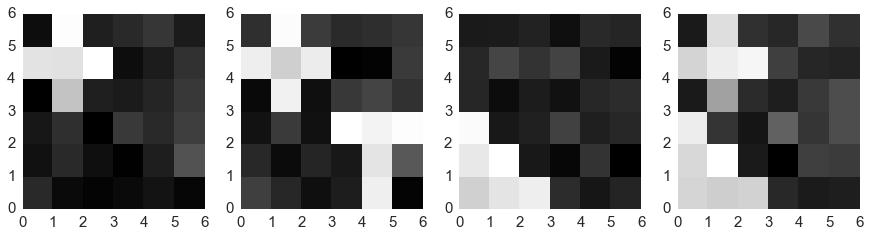

In [14]:

plt.figure(num=None, figsize=(15,3.5), dpi=100, facecolor='w', edgecolor='k')
plt.subplot(141)
plt.pcolormesh(XRecreated[9,:].reshape(6,6),cmap=plt.cm.gray)
plt.subplot(142)
plt.pcolormesh(XRecreated[74,:].reshape(6,6),cmap=plt.cm.gray)
plt.subplot(143)
plt.pcolormesh(XRecreated[10,:].reshape(6,6),cmap=plt.cm.gray)
plt.subplot(144)
plt.pcolormesh(XRecreated[21,:].reshape(6,6),cmap=plt.cm.gray)

From left to right: 1000, 1001, 0110, 1110


**Accelaration Option1: Concurrent Parallization**

In [10]:
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

In [13]:
niter = 1000
sigmaX = 1.7
sigmaA = 0.5
alpha = 1.0
maxNew = 4
BURN_IN=200
SAMPLE_SIZE= niter-BURN_IN

In [14]:
%%time
start = time.clock()
final_Z, final_K, final_sigma_A, final_sigma_X, final_alpha, Z= sampler(X, niter, BURN_IN, sigmaX, sigmaA,alpha, N, D, maxNew)
end1 = time.clock() - start

CPU times: user 11min 31s, sys: 5.83 s, total: 11min 37s
Wall time: 5min 57s


In [15]:
%%time
start = time.clock()
with ProcessPoolExecutor(max_workers=8) as pool:
    res = pool.submit(sampler, X, niter, BURN_IN, sigmaX, sigmaA,alpha, N, D, maxNew)
end2 = time.clock() - start

CPU times: user 257 ms, sys: 105 ms, total: 362 ms
Wall time: 4min 55s


In [16]:
end1/end2

1928.851298905983

Speed up greatly!

**Accelaration Option2: Cython**

In [39]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [55]:
%%file Cython_functions.pyx
import numpy as np

cimport numpy as np

def IBP_prior(double alpha, int N):
    cdef double p
    cdef int i,j,K_plus,temp
    cdef np.ndarray res
    
    res = np.zeros((N, 1000))
    
    temp = np.random.poisson(alpha)
    if temp>0:
        res[0,0:temp] = np.ones(temp)

    K_plus = temp
    for i in range(1,N):
        for j in range(K_plus):
            p = np.sum(res[0:i,j])/(i+1)
            if np.random.uniform(0,1) < p:
                res[i,j] = 1
        temp = np.random.poisson(alpha/(i+1))
        if temp > 0:
            res[i, K_plus : K_plus + temp] = np.ones(temp)
            K_plus = K_plus + temp
    
    res = res[:,0:K_plus]
    return np.array((res, K_plus))

#log p(X|Z,σ_x ,σ_A )
def log_p(X, Z, double sigmaX, double sigmaA, int K, int D, int N):
    M = Z.T.dot(Z)+(sigmaX**2/sigmaA**2)*np.identity(K)
    return (-0.5)*N*D*np.log(2*np.pi) - (N-K)*D*np.log(sigmaX) - K*D*np.log(sigmaA) -0.5*D*np.log(np.linalg.det(M)) \
        -0.5/(sigmaX**2)*np.trace((X.T.dot(np.identity(N)-Z.dot(np.linalg.inv(M).dot(Z.T)))).dot(X))

Overwriting Cython_functions.pyx


In [65]:
%%file Cython_setup.py

from distutils.core import setup, Extension
from Cython.Build import cythonize
import numpy as np

ext = Extension("Cython_functions",
                sources=["Cython_functions.pyx"],
                include_dirs=[np.get_include()],
                libraries=["m"],
                extra_compile_args=["-w",  "-std=c99"])

setup(name = "Cy_Funcs",
      ext_modules = cythonize(ext),
     include_dirs=[np.get_include()])

Overwriting Cython_setup.py


In [66]:
! python Cython_setup.py clean
! python Cython_setup.py -q build_ext --inplace

running clean
removing 'build/temp.macosx-10.5-x86_64-3.5' (and everything under it)
removing 'build'


In [67]:
import Cython_functions
alpha = 1
sigmaX = 1.7
sigmaA = 0.5
N=Z_zero.shape[0]
D=Z_zero.shape[1]
Z, Kplus = IBP_prior(alpha, N)
%timeit log_p(Z_zero, Z, sigmaX, sigmaA, Kplus, D, N)

The slowest run took 5.59 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 119 µs per loop


In [69]:
%%file sampler_cy.py
import numpy as np
import scipy as sp
import math
import Cython_functions as func

def cython_sampler(X, niter, BURN_IN, sigmaX, sigmaA,alpha, N, D, maxNew):
    SAMPLE_SIZE=niter-BURN_IN
    
    final_Z=np.zeros((SAMPLE_SIZE,N,20))
    final_K=np.zeros((SAMPLE_SIZE,1))
    final_sigma_X=np.zeros((SAMPLE_SIZE,1))
    final_sigma_A=np.zeros((SAMPLE_SIZE,1))
    final_alpha=np.zeros((SAMPLE_SIZE,1))
    Z, Kplus = func.IBP_prior(alpha, N)
    count=0

    for j in range(niter):
        if((j+1) > BURN_IN):
            final_Z[count,:,0:Kplus] = Z
            final_K[count] = Kplus
            final_sigma_X[count] = sigmaX
            final_sigma_A[count] = sigmaA
            final_alpha[count] = alpha
            count = count + 1

        for i in range(N):
            for k in range(Kplus):
                if k >= Kplus:
                    break     
                if Z[i,k] > 0:
                    if (np.sum(Z[:,k])- 1) <= 0:
                        Z[:,k:(Kplus-1)] = Z[:,(k+1):Kplus]
                        Kplus = Kplus-1
                        Z = Z[:,0:Kplus]
                        continue
           
           #M-H algorithm for Z
                P = np.zeros(2)
                #set Z[i,k] = 0 and calculate posterior probability
                Z[i,k] = 0
                P[0] = func.log_p(X, Z, sigmaX, sigmaA, Kplus, D, N) + np.log(N-np.sum(Z[:,k])) - np.log(N)
                #set Z[i,k] = 1 and calculate posterior probability
                Z[i,k] = 1
                P[1] = func.log_p(X, Z,sigmaX, sigmaA, Kplus, D, N)  + np.log(np.sum(Z[:,k])- 1) - np.log(N)

                P = np.exp(P - max(P))
                U = np.random.uniform(0,1)
                if U<(P[1]/(np.sum(P))):
                    Z[i,k] = 1
                else:
                    Z[i,k] = 0   
  
            #M-H algorithm for k
            # Set the number of upper bound as 3
            maxNew = 3
            #Sample number of new features
            prob = np.zeros(maxNew)
            alphaN = alpha/N     
            for kNew in range(maxNew):
                Z_temp = Z
                if kNew > 0:
                    addCols = np.zeros((N,kNew))
                    addCols[i,:] = 1
                    Z_temp = np.hstack((Z_temp, addCols))

                pois = kNew*np.log(alphaN) - alphaN - np.log(math.factorial(kNew))
                kk = Kplus+kNew
                lik = func.log_p(X, Z_temp, sigmaX, sigmaA, kk, D, N)
                prob[kNew] = pois + lik
            prob = np.exp(prob - max(prob))
            prob = prob/sum(prob)

            U = np.random.uniform(0,1)
            p = 0
            kNew=0
            for new in range(maxNew):
                p = p + prob[new]
                if U < p:
                    kNew = new
                    break
            if kNew > 0:
                addCols = np.zeros((N,kNew))
                addCols[i,:] = 1
                Z = np.hstack((Z, addCols))
            Kplus = Kplus + kNew 
        Log_L1 = func.log_p(X, Z, sigmaX, sigmaA, Kplus, D, N )

        #update sigmaX  
        temp_unif = np.random.uniform(0,1)/30
        if np.random.uniform(0,1) < .5:
            sigmaX_new = sigmaX - temp_unif
        else:
            sigmaX_new = sigmaX + temp_unif
    
        Log_L_New = func.log_p(X, Z, sigmaX_new, sigmaA, Kplus, D, N)
        sigmaX_a = np.exp(min(0,Log_L_New-Log_L1))       
        U = np.random.uniform(0,1)
        if U < sigmaX_a:
            sigmaX = sigmaX_new


        #update sigmaA
        temp_unif1 = np.random.uniform(0,1)/30
        if np.random.uniform(0,1) < .5:
            sigmaA_new = sigmaA - temp_unif1
        else:
            sigmaA_new = sigmaA + temp_unif1
    
        Log_L_New = func.log_p(X, Z, sigmaX, sigmaA_new, Kplus, D, N)
        sigmaX_a = np.exp(min(0,Log_L_New-Log_L1))
        U = np.random.uniform(0,1)
        if U < sigmaX_a:
            sigmaA = sigmaA_new
        
        #update alpha
        Harmonic_N = 0.
        for i in range(1, N+1):
            Harmonic_N += 1.0/i
        alpha = np.random.gamma(1+Kplus, 1/(1+Harmonic_N))  
 
    return(final_Z, final_K, final_sigma_A, final_sigma_X, final_alpha, Z)

Overwriting sampler_cy.py


In [28]:
niter = 1000
sigmaX = 1.7
sigmaA = 0.5
alpha = 1.0
maxNew = 4
BURN_IN=200
SAMPLE_SIZE= niter-BURN_IN

In [26]:
%timeit cython_sampler(X, niter, BURN_IN, sigmaX, sigmaA,alpha, N, D, maxNew)
%timeit sampler(X, niter, BURN_IN, sigmaX, sigmaA,alpha, N, D, maxNew)

NameError: name 'cython_sampler' is not defined